In [1]:
# I run this notebook on my local machine, so you need to pip install all necessary packages
import boto3
import pandas as pd
import json
import matplotlib.pyplot as plt 
from time import time
import psycopg2
import configparser
import numpy as np

In [2]:
# 
config = configparser.ConfigParser()
config.read_file(open('redshift-config.cfg'))

KEY                    = config.get('IAM_USER', 'KEY')
SECRET                 = config.get('IAM_USER', 'SECRET')


IAM_ROLE_NAME          = config.get('IAM_ROLE', 'IAM_ROLE_NAME')


CLUSTER_IDENTIFIER     = config.get('AWS', 'CLUSTER_IDENTIFIER')
CLUSTER_TYPE           = config.get('AWS', 'CLUSTER_TYPE')
NUM_NODES              = config.get('AWS', 'NUM_NODES')
NODE_TYPE              = config.get('AWS', 'NODE_TYPE')


DB_NAME                = config.get('CLUSTER', 'DB_NAME')
DB_USER                = config.get('CLUSTER', 'DB_USER')
DB_PASSWORD            = config.get('CLUSTER', 'DB_PASSWORD')
DB_PORT                = config.get('CLUSTER', 'DB_PORT')


#DWH_IAM_ROLE_NAME      = config.get('DWH', 'DWH_IAM_ROLE_NAME' )

""" I ll need to configparse ARN the next time after creating ARN, not the first time 
ARN                    = config.get('IAM_ROLE','ARN')
ARN2                   = config.get('IAM_ROLE','ARN2')"""

" I ll need to configparse ARN the next time after creating ARN, not the first time \nARN                    = config.get('IAM_ROLE','ARN')\nARN2                   = config.get('IAM_ROLE','ARN2')"

In [4]:
pd.DataFrame({"Params":
              [ "CLUSTER_IDENTIFIER","CLUSTER_TYPE", "NUM_NODES","NODE_TYPE","DB_NAME","DB_USER",\
               "DB_PASSWORD","DB_PORT", "IAM_ROLE_NAME"  ],
             "Values":
             [ CLUSTER_IDENTIFIER,CLUSTER_TYPE, NUM_NODES,NODE_TYPE,DB_NAME,DB_USER,\
               DB_PASSWORD,DB_PORT, IAM_ROLE_NAME]})

,Params,Values
0,CLUSTER_IDENTIFIER,capstone-project-2021
1,CLUSTER_TYPE,multi-node
2,NUM_NODES,4
3,NODE_TYPE,dc2.large
4,DB_NAME,my_database
5,DB_USER,database_user-12
6,DB_PASSWORD,projectPassw0rd
7,DB_PORT,5439
8,IAM_ROLE_NAME,iamRoleName


### Client for IAM, EC2, S3, and RedShift 

In [5]:
ec2 = boto3.resource('ec2', 
                    region_name="us-west-2",
                    aws_access_key_id     = KEY,
                    aws_secret_access_key = SECRET
                    )

s3 = boto3.resource('s3',
                   region_name='us-west-2',
                   aws_access_key_id      = KEY,
                   aws_secret_access_key  = SECRET
                   )

iam = boto3.client('iam', 
                region_name='us-west-2',
                aws_access_key_id         = KEY,
                aws_secret_access_key     = SECRET
                )

redshift = boto3.client('redshift',
                      region_name='us-west-2',
                      aws_access_key_id    = KEY,
                      aws_secret_access_key= SECRET
                      )

## STEP1 : IAM ROLE
##### Create an IAM Role that enables RedShift to access S3 bucket ( ReadOnly) 

In [6]:
"""from botocore.exceptions import ClientError

#1.1 Create the role
try:
    print("1.1 Creating a new IAM Role called Omaar-IAM-FOR-AIRFLOW") 
    dwhRole = iam.create_role(
        Path='/',
        RoleName=IAM_ROLE_NAME,
        Description = "Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {'Statement': [{'Action': 'sts:AssumeRole','Effect': 'Allow','Principal': {'Service': 'redshift.amazonaws.com'}}],
             'Version': '2012-10-17'})
    )    
except Exception as e:
    print(e)
    

print("1.2 Attaching Policy")

iam.attach_role_policy(RoleName=IAM_ROLE_NAME,PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess")['ResponseMetadata']['HTTPStatusCode']
"""
print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName=IAM_ROLE_NAME)['Role']['Arn']


print(roleArn)

1.3 Get the IAM role ARN
arn:aws:iam::185187464837:role/iamRoleName


## STEP2: Redshift Cluster
##### Create a RedShift Cluster

In [7]:
try:
    response= redshift.create_cluster( ClusterType   = CLUSTER_TYPE,
                                  NodeType           = NODE_TYPE,
                                  NumberOfNodes      = int(NUM_NODES),
                                  
                                  #identifiers & credentials
                                  DBName             = DB_NAME,
                                  ClusterIdentifier  = CLUSTER_IDENTIFIER,
                                  MasterUsername     = DB_USER,
                                  MasterUserPassword = DB_PASSWORD,
                                  
                                  #Roles ( for s3 access)
                                  IamRoles = [roleArn] 
                                 )
except Exception as e:
    print(e)

#### Describe the cluster to see its status 

In [8]:
def description (props):
    pd.set_option('display.max_colwidth',None)
    keyToShow= ["ClusterIdentifier", "NodeType", "ClusterStatus", "MasterUsername", "DBName", "Endpoint", "NumberOfNodes", 'VpcId']
    x = [(k,v) for k,v in props.items() if k in keyToShow]
    return pd.DataFrame(data=x,columns=['Key','Value'])
myClusterProps = redshift.describe_clusters(ClusterIdentifier=CLUSTER_IDENTIFIER)['Clusters'][0]
description( myClusterProps)

,Key,Value
0,ClusterIdentifier,capstone-project-2021
1,NodeType,dc2.large
2,ClusterStatus,creating
3,MasterUsername,database_user-12
4,DBName,my_database
5,VpcId,vpc-61eca419
6,NumberOfNodes,4


In [ ]:
# do not run this for the first time 
#if a psycopg2 execution fails please run the this cell to close the connection and reconnect
conn.close()

In [9]:
# this one is functional ( les parametre dans cfg sont dans l'order pour CLUSTER ) 
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur=conn.cursor()

## STEP 3 : Import data, check it and do analysis

### Drop tables if they exist

In [10]:
date_time_drop="DROP TABLE IF EXISTS date_time CASCADE"
calendar_drop="DROP TABLE IF EXISTS calendar CASCADE"
location_drop="DROP TABLE IF EXISTS location CASCADE"
hosts_drop="DROP TABLE IF EXISTS hosts CASCADE"
listings_drop="DROP TABLE IF EXISTS listings CASCADE"
reviewers_drop="DROP TABLE IF EXISTS reviewers CASCADE"
reviews_drop="DROP TABLE IF EXISTS reviews CASCADE"

In [11]:
drop_all_tables=[date_time_drop,calendar_drop, location_drop,hosts_drop,reviewers_drop,listings_drop ,reviews_drop]

In [12]:
for query in drop_all_tables:
    cur.execute(query)
    conn.commit()

### Create tables 

In [13]:
date_time_create="""CREATE TABLE IF NOT EXISTS date_time(
date date PRIMARY KEY ,
day_of_month integer,
week integer,
month integer,
year integer,
day varchar)
"""
calendar_create="""
CREATE TABLE IF NOT EXISTS calendar(
calendar_id integer PRIMARY KEY,
listing_id integer references listings (id),
date date references date_time(date),
available boolean,
price float)
"""
location_create="""
CREATE TABLE IF NOT EXISTS location(
location_id integer PRIMARY KEY, 
latitude float,
longitude float,
street VARCHAR ,
zipcode VARCHAR,
city VARCHAR,
country VARCHAR
)

"""

hosts_create="""CREATE TABLE IF NOT EXISTS hosts (
host_id integer PRIMARY KEY, 
host_name varchar  , 
host_about varchar (10000), 
host_response_time varchar, 
host_response_rate float,
host_is_superhost boolean,
host_location varchar,
host_identity_verified boolean
)
"""
listings_create="""
CREATE TABLE IF NOT EXISTS listings (
id integer PRIMARY KEY,
host_id integer references hosts(host_id),
location_id integer references location (location_id),
price float,
weekly_price float,
monthly_price float,
security_deposit float ,
cleaning_fee float ,
guests_included float,
extra_people float,
listing_url varchar,
property_type varchar ,
accommodates integer,
room_type varchar ,
bathrooms float,
bedrooms float,
beds float,
bed_type varchar,
amenities varchar (9000),
review_scores_rating float,
review_scores_accuracy float,
review_scores_cleanliness float,
review_scores_location float,
review_scores_value float,
cancellation_policy varchar,
require_guest_profile_picture boolean,
require_guest_phone_verification boolean)
"""
reviewers_create="""CREATE TABLE IF NOT EXISTS reviewers (
reviewer_id integer PRIMARY KEY,
reviewer_name varchar )"""

reviews_create="""CREATE TABLE IF NOT EXISTS reviews(
id integer PRIMARY KEY,
listing_id integer references listings (id),
date date references date_time(date),
reviewer_id integer references reviewers (reviewer_id),
comments varchar (10000)
)
"""

In [14]:
create_table_queries=[date_time_create, location_create,\
                      hosts_create, listings_create, calendar_create,reviewers_create, reviews_create]

In [15]:
for query in create_table_queries:
    cur.execute(query)
    conn.commit()

### Copy from S3 into Redshift

In [16]:
date_time_copy=(""" copy date_time  from {} iam_role '{}' format as parquet ;""").\
format(config['S3']['date_time'],config['IAM_ROLE']['ARN'])

In [17]:
calendar_copy=(""" 
copy calendar from {} 
iam_role '{}'
format as parquet ;""").format(config['S3']['calendar'],config['IAM_ROLE']['ARN'])

In [18]:
location_copy=(""" 
copy location from {} 
iam_role '{}'
format as parquet  ;""").format(config['S3']['location'],config['IAM_ROLE']['ARN'])

In [19]:
hosts_copy=(""" 
copy hosts from {} 
iam_role '{}'
format as parquet  ;""").format(config['S3']['hosts'],config['IAM_ROLE']['ARN'])

In [20]:
listings_copy=(""" 
copy listings from {} 
iam_role '{}'
format as parquet ;""").format(config['S3']['listings'],config['IAM_ROLE']['ARN'])

In [21]:
reviewers_copy=(""" 
copy reviewers from {} 
iam_role '{}'
format as parquet ;""").format(config['S3']['reviewers'],config['IAM_ROLE']['ARN'])

In [22]:
reviews_copy=(""" 
copy reviews from {} 
iam_role '{}'
format as parquet  ;""").format(config['S3']['reviews'],config['IAM_ROLE']['ARN'])

In [23]:
copy_all_tables={'date_time':date_time_copy,'calendar':calendar_copy,\
                 'location':location_copy,'hosts':hosts_copy,\
                 'listings':listings_copy, 'reviewers':reviewers_copy, 'reviews':reviews_copy}

In [24]:
for query in copy_all_tables:
    t0=time()
    cur.execute(copy_all_tables[query])
    conn.commit()
    copyTime=time()-t0
    print("=== COPYING TABLE __{}__ IS DONE IN : {} sec\n ". format(query,copyTime))

=== COPYING TABLE __date_time__ IS DONE IN : 14.369196891784668 sec
 
=== COPYING TABLE __calendar__ IS DONE IN : 9.001993179321289 sec
 
=== COPYING TABLE __location__ IS DONE IN : 3.066822052001953 sec
 
=== COPYING TABLE __hosts__ IS DONE IN : 8.107087850570679 sec
 
=== COPYING TABLE __listings__ IS DONE IN : 8.379455089569092 sec
 
=== COPYING TABLE __reviewers__ IS DONE IN : 5.819473743438721 sec
 
=== COPYING TABLE __reviews__ IS DONE IN : 5.169198036193848 sec
 


## Run Quality Check

In [25]:
query1="SELECT count(*) FROM date_time;"
query2="SELECT count(*) FROM calendar;"
query3="SELECT count(*) FROM location;"
query4="SELECT count(*) FROM hosts;"
query5="SELECT count(*) FROM listings;"
query6="SELECT count(*) FROM reviewers;"
query7="SELECT count(*) FROM reviews;"
count_queries={"date_time_records_count":query1, "calendar_records_count":query2, "location_records_count":query3,\
             "hosts_records_count":query4, "listings_records_count":query5,"reviewers_records_count":query6,\
             "reviews_records_count":query7}

#### record count per table

In [26]:
for query in count_queries:
    cur.execute(count_queries[query])
    rows=cur.fetchall()
    conn.commit()
    print(query,":",rows[0][0])

date_time_records_count : 3240
calendar_records_count : 7310950
location_records_count : 20029
hosts_records_count : 17263
listings_records_count : 20006
reviewers_records_count : 411813
reviews_records_count : 431830


### Analysis

#### min, max, and average price of all the available listings 

In [27]:
query="""SELECT min (price), max (price), avg (price) FROM calendar; """
cur.execute(query)
rows=cur.fetchall()
conn.commit()
print("The minimum price of a listing is ${}, maximum price is ${} , and average price is ${}"\
      .format(rows[0][0], rows[0][1], rows[0][2]))

The minimum price of a listing is $9.0, maximum price is $8500.0 , and average price is $207.655591210853


#### average price per listing: top10 

In [28]:
query="""SELECT listing_id, AVG ( price) as average_price FROM calendar \
GROUP BY (listing_id) HAVING average_price is not null
ORDER BY ( average_price) DESC LIMIT 10;"""

In [29]:
cur.execute(query)
rows=cur.fetchall()
conn.commit()
for row in rows:
    print( "The average price of the listing __{}__ is ${}".format(row[0], row[1]))

The average price of the listing __12213707__ is $8500.0
The average price of the listing __258273__ is $8000.0
The average price of the listing __5587500__ is $4782.96703296703
The average price of the listing __25349319__ is $3900.0
The average price of the listing __15626614__ is $3142.0
The average price of the listing __28651212__ is $3000.0
The average price of the listing __11040717__ is $2500.0
The average price of the listing __19559616__ is $2500.0
The average price of the listing __28973126__ is $2257.50699300699
The average price of the listing __17525867__ is $2200.0


The listings '12213707' & '258273' must be luxurious 

#### top recurrent prices

In [30]:
query="""SELECT average_price, count(average_price) as counts FROM (SELECT listing_id, AVG ( price) as average_price FROM calendar \
GROUP BY (listing_id) HAVING average_price is not null) GROUP BY average_price ORDER BY counts DESC LIMIT 10  ;"""

In [31]:
cur.execute(query)
rows=cur.fetchall()
conn.commit()
data=pd.DataFrame(rows, columns=['average_price', 'counts'])

In [32]:
data

,average_price,counts
0,150.0,255
1,100.0,180
2,120.0,175
3,200.0,145
4,125.0,131
5,250.0,123
6,140.0,121
7,175.0,99
8,110.0,95
9,180.0,91


The majority of the listings' prices are between 100 & 150 dollars

#### Number of available listings per month

In [33]:
query=""" SELECT MIN (date), MAX (date) FROM calendar;"""
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [34]:
rows

[(datetime.date(2018, 12, 6), datetime.date(2019, 12, 6))]

In [35]:
query="""SELECT dt.month, COUNT(DISTINCT ((listing_id))) 
         FROM calendar as cal
         JOIN date_time as dt on dt.date=cal.date
         WHERE cal.available = true
         GROUP BY  dt.month 
         ORDER BY  dt.month"""

In [36]:
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [37]:
for row in rows :
    print(row)

(1, 7269)
(2, 5867)
(3, 5557)
(4, 4089)
(5, 4188)
(6, 4178)
(7, 3282)
(8, 3330)
(9, 3317)
(10, 3157)
(11, 3156)
(12, 8750)


In [38]:
data=pd.DataFrame(rows, columns=['month', 'listings_per_month'])

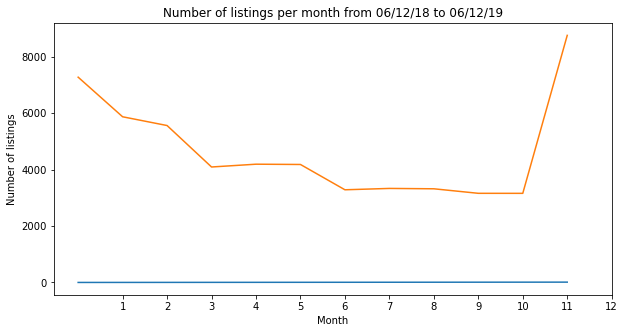

In [39]:
plt.figure(figsize=(10,5))
plt.plot(data)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month from 06/12/18 to 06/12/19')

plt.show()

The diagram above shows that availability descreases in the summer to october ==> it reflects that people tends to travel to Amsterdam in summer

In [40]:
query = """SELECT room_type, count(id) counts FROM listings GROUP BY room_type ORDER BY counts DESC """

In [41]:
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [42]:
rows

[('Entire home/apt', 15874), ('Private room', 4067), ('Shared room', 65)]

#### number of listings per host 

In [43]:
query="""SELECT listings.host_id, host_name, COUNT(listings.id) as counts FROM listings 
         JOIN hosts ON listings.host_id=hosts.host_id
         GROUP BY listings.host_id, host_name ORDER BY counts DESC LIMIT 10"""

In [44]:
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [45]:
rows

[(65859990, 'Martijn', 208),
 (1464510, 'Michiel And Jane', 105),
 (76104209, 'Rated', 83),
 (113977564, 'Willem', 38),
 (517215, 'Niels En Viv (Welcome Back)', 30),
 (107745142, 'Oscar', 27),
 (14183886, 'Luis', 25),
 (11969034, 'Raul', 24),
 (44168250, 'Ruben', 21),
 (7594884, 'Ruben, Sarah & Lindy', 21)]

As for these hosts having more than 20 listings, it is obvious that this it about professional hosting activities which is forbidden within AirBnB

to know more about these hosts (I pick one 'Martijn') , below I issued an sql query to know more about him 

In [46]:
query="""SELECT host_id, host_about from hosts where host_id='65859990'  ;"""
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [47]:
rows

[(65859990,
  "Hi, I'm Martijn, \r\n\r\nWe are a team of professional hosts established by travelers just like you. We believe in sharing homes. Wherever you are, it is delightful to explore and discover an unknown city from an authentic home. \r\n\r\nOn behalf of home owners we advertise their properties through our airbnb profile and support them by offering you a pleasant stay. \r\n\r\nWhen you book your holiday with us, you can be confident of a memorable stay and an experience through the eyes of a local. We are more than happy to share our knowledge, give you the best insider tips and recommendations about Amsterdam.\r\n\r\nIf you have any questions, holiday wishes or simply want to have a chat, then feel free to contact us any time. We always reply within an hour!\r\n\r\nWe look forward to being your host! :)")]

#### Most expensive strest in Amsterdam

In [48]:
query="""SELECT AVG (calendar.price) average_price, street 
         from calendar JOIN listings ON calendar.listing_id=listings.id 
                       JOIN location ON listings.location_id= location.location_id
         WHERE calendar.available is true
         GROUP BY street  ORDER BY average_price DESC LIMIT 10;"""

In [49]:
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [50]:
rows

[(597.578796561605, 'Amsterdam, GD, Netherlands'),
 (494.092024539877, 'Amsterdam, Emmy andriessestraat, Netherlands'),
 (431.01677852349, 'Amsterdam , Amsterdam, Netherlands'),
 (380.578512396694, 'Amsterdam, Nassaukade, Netherlands'),
 (265.0, 'Zaandam, Noord-Holland, Netherlands'),
 (239.0, 'Amsterdam, GE, Netherlands'),
 (231.0663507109, 'Amsterdam, Amsterdam, Netherlands'),
 (228.62466901158, 'Amsterdam, Netherlands'),
 (215.307090061015, 'Amsterdam, Noord-Holland, Netherlands'),
 (213.705882352941, 'Amsterdam, CE, Netherlands')]

below a list of the 10 most expensive streets in Amsterdam

#### most interactive reviewers 

In [51]:
query =""" SELECT reviewers.reviewer_id, reviewer_name, count(reviews.id) as counts from reviews
JOIN reviewers ON reviews.reviewer_id=reviewers.reviewer_id 
GROUP BY reviewers.reviewer_id, reviewer_name 
ORDER BY counts DESC LIMIt 10"""
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [52]:
rows

[(12574897, 'Michel', 25),
 (44092711, 'Markus', 20),
 (11318929, 'Philippe', 18),
 (2644225, 'Joeran', 14),
 (24554860, 'Sidney', 13),
 (8749900, 'Joshua', 12),
 (1291027, 'Andrea', 11),
 (9426660, 'Thomas', 11),
 (35708120, 'Jim', 11),
 (7647712, 'Bernard', 11)]

#### Number of reviews per listing and their corresponding average review rating 

In [53]:
query =""" SELECT reviews.listing_id, count(reviews.id) as counts,AVG(listings.review_scores_rating)  from reviews
JOIN listings ON reviews.listing_id=listings.id 
GROUP BY reviews.listing_id
ORDER BY counts DESC LIMIt 10"""
cur.execute(query)
rows=cur.fetchall()
conn.commit()

In [54]:
rows

[(82482, 695, 88.0),
 (1469096, 631, 94.0),
 (1814121, 606, 94.0),
 (785432, 602, 95.0),
 (152280, 580, 88.0),
 (694850, 576, 96.0),
 (68290, 574, 96.0),
 (654931, 541, 96.0),
 (239647, 540, 96.0),
 (68873, 527, 96.0)]

listings '82482', '1469096' have more than 631 reviews but '1469096' seems to have more positive feedbacks

## STEP 4 : Clean up AWS resources 

In [55]:
redshift.delete_cluster(ClusterIdentifier= CLUSTER_IDENTIFIER, SkipFinalClusterSnapshot= True)

{'Cluster': {'ClusterIdentifier': 'capstone-project-2021',
  'NodeType': 'dc2.large',
  'ClusterStatus': 'deleting',
  'ClusterAvailabilityStatus': 'Modifying',
  'MasterUsername': 'database_user-12',
  'DBName': 'my_database',
  'Endpoint': {'Address': 'capstone-project-2021.cahjwy6ny05j.us-west-2.redshift.amazonaws.com',
   'Port': 5439},
  'ClusterCreateTime': datetime.datetime(2021, 1, 18, 14, 20, 0, 279000, tzinfo=tzutc()),
  'AutomatedSnapshotRetentionPeriod': 1,
  'ManualSnapshotRetentionPeriod': -1,
  'ClusterSecurityGroups': [],
  'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-1d670a33',
    'Status': 'active'}],
  'ClusterParameterGroups': [{'ParameterGroupName': 'default.redshift-1.0',
    'ParameterApplyStatus': 'in-sync'}],
  'ClusterSubnetGroupName': 'default',
  'VpcId': 'vpc-61eca419',
  'AvailabilityZone': 'us-west-2b',
  'PreferredMaintenanceWindow': 'sat:11:00-sat:11:30',
  'PendingModifiedValues': {},
  'ClusterVersion': '1.0',
  'AllowVersionUpgrade': True,
  'Nu

In [56]:
myClusterProps=redshift.describe_clusters(ClusterIdentifier= CLUSTER_IDENTIFIER)['Clusters'][0]
description( myClusterProps)


,Key,Value
0,ClusterIdentifier,capstone-project-2021
1,NodeType,dc2.large
2,ClusterStatus,deleting
3,MasterUsername,database_user-12
4,DBName,my_database
5,Endpoint,"{'Address': 'capstone-project-2021.cahjwy6ny05j.us-west-2.redshift.amazonaws.com', 'Port': 5439}"
6,VpcId,vpc-61eca419
7,NumberOfNodes,4
